# Test File - Pushing to Git

Git use is successful - set up and saving ok.

# Aims for this notebook:
- Import data from the scan feature in ImageJ
- Plot data (normalise) and fit to Gaussians to find waist values 
- Plot all waist values against z distance to extropolate back and find w0

## Import all useful libraries / tools

In [340]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

## Import Data

Function below that takes path and returns distances and amplitudes from all csv files in that folder, as np.ndarrays in a big list

In [341]:
def import_data(global_path):

    # Function which finds filenames of csvs in a folder
    def find_csv_filenames( path_to_dir, suffix=".csv" ):
        filenames = listdir(path_to_dir)
        return [ filename for filename in filenames if filename.endswith( suffix ) ]

    # the list of files in the folder
    files_list = find_csv_filenames(global_path)

    # empty lists to put values in
    distances = []
    amps = []

    # loop through file names in directory
    for f in range(len(files_list)):

        # Import an execl sheet as dataframe, called 'Values1'
        # NB: Image J seems to have saved this 'excel sheet' as a csv file
        df_test = pd.read_csv(global_path + files_list[f])

        # Extracing a column by title and converting data to array
        distances.append(np.array(df_test['Distance_(microns)']))
        amps.append(np.array(df_test['Gray_Value']))

    # returning arrays within two big lists
    return distances, amps

In [342]:
# Define useful path to data
globalpath = "D:/1. L4 Project/Fibres/2023-11-28/Data-Photo2/"

In [343]:
distances, amplitudes = import_data(globalpath)

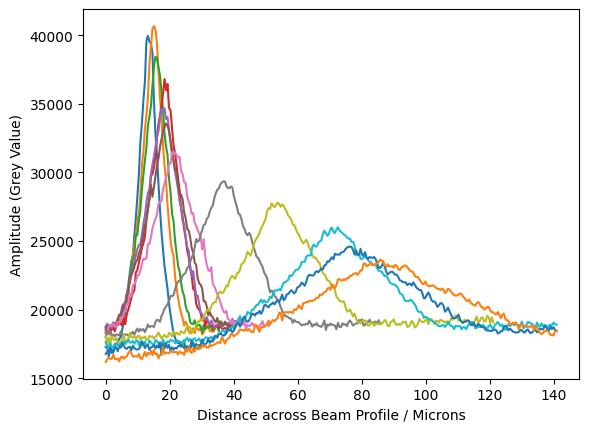

In [344]:
for i in range(12):
    plt.plot(distances[i][0:300], amplitudes[i][0:300])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [345]:
def data_trim(distances_, amplitudes_, cutoff):

    '''A function to tidy up the raw gaussian data. Implements measures to normalise and trasform data such that
    the only fitting parameter becomes the waist of the beam, W. '''

    new_distances = []
    new_amps = [] # some empty lists to append to at the end of the loop

    for j in range(len(distances_)): # iterate through distances (amps)

        # Get rid of vertical offset - to reduce a fitting parameter
        subt_amp = amplitudes_[j] - np.min(amplitudes_[j])

        # Normalise data by its maximum value
        norm_amp = subt_amp / np.max(subt_amp)

        dist_max = 0 # to add to later

        # Move data so centred on zero - reduce fitting params further
        for i in range(norm_amp.size):
            if norm_amp[i] == np.max(norm_amp):
                dist_max = distances_[j][i]

        shifted_distances = distances_[j] - dist_max

        cut_dist = 0
        cut_amps = 0

        if len(shifted_distances) > cutoff:
            cut_dist = shifted_distances[0:cutoff]
            cut_amps = norm_amp[0:cutoff]

            # Add adjusted data set to the new large lists
            new_distances.append(cut_dist)
            new_amps.append(cut_amps)

        else:
            new_distances.append(shifted_distances)
            new_amps.append(norm_amp)

    return new_distances, new_amps

In [346]:
all_distances, all_amps = data_trim(distances, amplitudes, 310)

Text(0, 0.5, 'Normalised Amplitude')

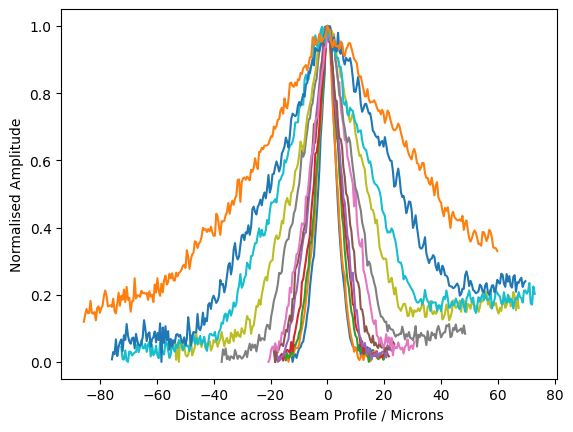

In [347]:
for i in range(12):
    plt.plot(all_distances[i], all_amps[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

## Fit Data

Defining useful functions - using chi squared and fit_labs, previously written

In [348]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

In [349]:
def fit_labs(xdata,ydata, yerrors, function, initial_guess):

    dof = np.size(xdata) - np.size(initial_guess) ## degrees of freedom

    if np.size(yerrors) == 1:

        yerr_extended = np.zeros(np.size(xdata))
        for i in range(np.size(yerr_extended)):
            yerr_extended[i] = yerrors

        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerr_extended, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    if yerrors == 0:

        parameters, covariance = curve_fit(function, xdata, ydata, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    else:
    
        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerrors, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    perrors = np.sqrt(np.diag(covariance))

    # chisq_min = chi_squared(parameters,
    #                     function, 
    #                     xdata, 
    #                     ydata, 
    #                     yerrors) 
    
    # chisq_reduced = chisq_min / dof

    # p_value = scipy.stats.chi2.sf(chisq_min, dof)

    yfit = function(xdata, *parameters)

    return yfit, parameters, perrors

In [350]:
def Gauss(x, W): ### Defien Gaussian with ONE parameter
    y = np.exp((-2*(x**2) / W**2))
    return y

c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:504: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


Text(0, 0.5, 'Waist Size / Microns')

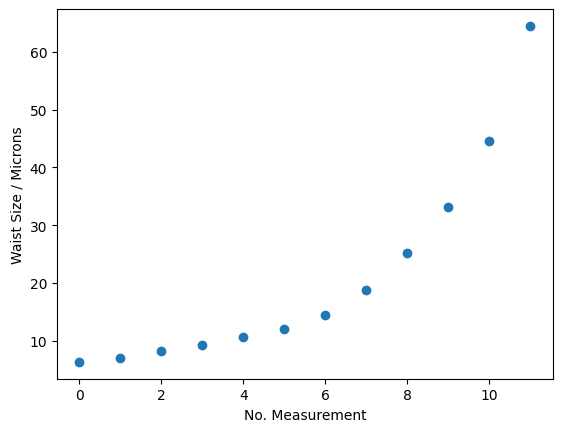

In [351]:
# Create some empty arrays to store values of interest
waists = np.zeros(len(all_distances))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
waist_errors = np.zeros(len(all_distances))

# Running fitting algorithm for 12x data sets
for i in range(len(all_distances)):
    singlefit, waists[i], waist_errors[i] = fit_labs(all_distances[i],all_amps[i], 0, Gauss, 10)
    y_fits.append(singlefit)

# Plot waist trend 
plt.scatter(np.arange(12),waists)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')

## Calculating Z values and Plotting Waist size against Z

In [352]:
# Define Global Path for where 'z' values are stored
z_path = 'D:/1. L4 Project/Fibres/2023-11-28/Data-Photo2/zs/'

# Import as dataframe
df_lengths = pd.read_csv(z_path + 'z-values.csv')

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['Length'])

In [353]:
print(lengths)

[  0.     11.862  28.302  42.964  59.407  74.086  98.652 134.007 178.825
 248.625 326.425 423.766]


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [354]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.405

In [355]:
# Define w vs z theoretical relation

def WvsZ(x, min_w, C):
    # define rayleigh range
    RR = (np.pi * min_w**2) / wavelength
    return min_w * np.sqrt(1 + ((x-C)/RR)**2)

In [356]:
print(np.cos(np.pi / 12))

0.9659258262890683


In [357]:
waist_fit, params, params_errs = fit_labs(lengths, waists, 0, WvsZ, np.array([1,-10]))
w0, z0 = params
w0_err, z0_err = params_errs

c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


[  0.96937374 -22.98744847] [0.01640713 3.4775782 ]


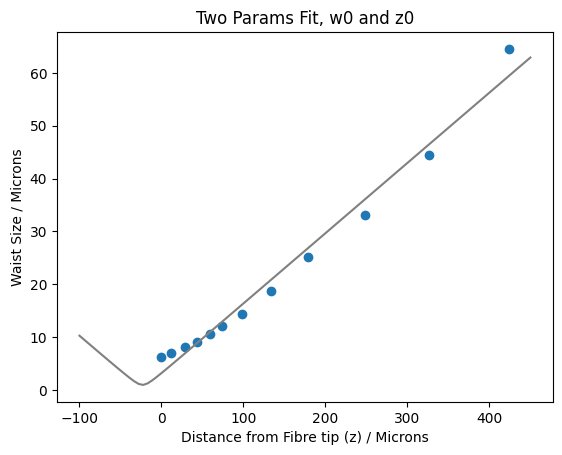

In [358]:
# Plot waists vs Z:
plt.scatter(lengths,waists)
plt.plot(np.linspace(-100,450,100), WvsZ(np.linspace(-100,450,100), w0, z0), color = 'grey')
plt.xlabel('Distance from Fibre tip (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Two Params Fit, w0 and z0')

print(params, params_errs)

## Comparison to Experiment - Ray Optics Model

In [359]:
# Defining Parameters of set-up

